# Курсовой проект. Анализ паблика в VK. 2020-03-20


Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 

## **TODO:**
* Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте).
* Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах).
* Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике.
* Выбрать нужные посты можно с помощью регулярных выражений.
* Составьте перечень рекомандаций для SMM-отдела по итогам анализа.

## Примечание ❗ - 2021-05-03
Иллюстрации и анализ данных проводился по данным: конец сентября 2018 - середина марта 2020 (1500 постов).

VK-API позволяет выгружать не более 100 постов, но не позволяет указать конкретную дату для выгрузки, для работы используется параметр `offset`.

Для получения необходимых данных была дописана функция `calc_offset` - которая вычисляет необходимые значения смещения для получения тех же постов, что были в работе. Изначально было выгружено:
* сентябрь 2018 - было выгружено 9 постов
* март 2020 - было выгружено 25 постов

# 1. Импорт библиотек, подключение к MondoDB, настройка 

## Импорт библиотек

In [1]:
from pymongo import MongoClient
from pymongo import UpdateOne
from extrans import pos_neg_comment_dic as comment_type
from extrans import categories_words_collection_dic as categories

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html
from pandas.io.json import json_normalize

### Магия при импорте модуля и дебаге

* Дебаг - https://ipython.org/ipython-doc/stable/interactive/magics.html#magic-pdb
* `%debug [--breakpoint FILE:LINE] [statement [statement ...]]` - можно установить breakpoint в нужном месте
* `%pdb 1` #- включить отладку (1), отключить(2) вызывает pdb !после того как появится traceback
* Отключить все брейкоинты в коде: `%env PYTHONBREAKPOINT = 0` - установить переменную окржуения
* Выбрать дебагер `%env PYTHONBREAKPOINT = ipdb.set_trace` - можно поменять на другой в Jupyter по молчанию `ipdb` - отличается от `pdb` - подсветкой синтаксеса и др.

### Импорт модуля - и его автоматическая перезагрузка при изменении
* Импорт модулей - https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
* `%load_ext autoreload` # загрузить модуль для перезагрузки внешних модулей
* `%autoreload 1` # перегружать все модули, которые были добавлены через %aimport и не перегружать все остальные параметр (1)
* `%aimport extrans` # импорт модуля и перезазгрузка его в случае изменения
* `%aimport` - показать текущие настройки, какие модули перезагружать, а какие пропускать

In [2]:
%load_ext autoreload
%autoreload 1
%aimport extrans
%aimport

Modules to reload:
extrans

Modules to skip:



## Настройка

In [3]:
#==================Параметры определяющие: делать ли загрузку новых постов, производить ли их обработку
GET_NEW_DATA = True # True\False - определяем получать ли новые данные
TRANSFORM_DATA = True # Производить ли обработку документов

#===================Переменные среды=============================================================
VK_TOKEN = None # если получам новые данные, то нужен ключ от приложения в VK : str
HOW_MANY_POSTS_TO_GET = 1500 # Сколько последних постов получить
OWNER_ID = -66669811 # ID паблика в VK, перед числом ставить минус

# Параметры для подключения к MongoBD
# VPS сделан в Google cloud (бесплатное обслуживание - https://cloud.google.com/free)
# Установлена Ubuntu + Docker
# `docker run -d --name sbox -p 27017:27017 -e MONGO_INITDB_ROOT_USERNAME=koslayn -e MONGO_INITDB_ROOT_PASSWORD=skillbox-test-vk mongo --auth`
# В фаерволе сделаны правила для пропуска входящего\исходящего трафика порт 27017

MC = {
    'host': '127.0.0.1',
    'port': 27017,
    'user': 'koslayn',
    'password': 'skillbox-test-vk',
    'authSource': 'admin'
}

## Подключение к MongoDB

In [4]:
# client = MongoClient(MC['host'], MC['port'], MC['user'], MC['password'])
client = MongoClient(f"mongodb://{MC['user']}:{MC['password']}@{MC['host']}:{ MC['port']}/{MC['authSource']}")
# Выбираем базу с которой будем работать
db = client['vk']
# Выбираем\Создаём коллекции для работы - как соединенеия с БД
# Созданы объекты, к атрибутам и методам которых можно обращаться
# Используются для поиска, модификации, удаления документов в коллекцих
coll_posts = db.posts
coll_comments = db.comments
coll_profiles = db.profiles

# 2. Получение данных и запись их в MongoDB
* Получаем посты, комментарии и профайлы и записываем в БД - `VK`:
  * Коллекции `coll_posts`, `coll_comments`, `coll_profiles`

In [5]:
from datetime import datetime
import time

In [6]:
# Получаем необходимые смещения:

start_date_index = 724 # 724 смещение на 3 мая 2021 года
start_date = datetime.fromisoformat('2020-03-13T13:50:11')

end_date_index = 2223 # 2223смещение на 3 мая 2021 года
end_date = datetime.fromisoformat('2018-09-27T16:25:31')

In [7]:
def calc_offset(current_offset_index, setted_date):
    # Простая функция для вычисления нужного смещения, создана для получения нужного смещения
    stop = 300
    while True:
        raw_posts = extrans.get_posts(count=1, offset=current_offset_index, OWNER_ID=OWNER_ID, VK_TOKEN=VK_TOKEN)
        parsed_posts = extrans.parse_json_vk_posts(raw_posts)
        getted_date = datetime.fromtimestamp(parsed_posts[0]['date'])
        if getted_date == setted_date:
            current_offset_index = current_offset_index
            print(f'Получено смещение: {current_offset_index}, {getted_date}')
            break
        else:
            current_offset_index += 1
            stop -= 1
            print(f'Текущее смещение: {current_offset_index}, {getted_date}')
        if stop == 0:
            print(f'Очень большое смещение, лучше поправить руками: {current_offset_index}, {getted_date}')
            break
        time.sleep(0.25)
    return current_offset_index

In [8]:
start_date_index = calc_offset(current_offset_index=start_date_index, setted_date=start_date)

end_date_index = calc_offset(current_offset_index=end_date_index, setted_date=end_date)

Текущее смещение: 725, 2020-03-15 12:55:45
Текущее смещение: 726, 2020-03-14 13:56:33
Текущее смещение: 727, 2020-03-13 19:13:28
Получено смещение: 727, 2020-03-13 13:50:11
Текущее смещение: 2224, 2018-09-28 11:43:18
Текущее смещение: 2225, 2018-09-27 21:30:02
Текущее смещение: 2226, 2018-09-27 17:30:01
Получено смещение: 2226, 2018-09-27 16:25:31


## 2.1. Запись постов в коллекцию

In [9]:
%%time
# Запись постов в коллекцию (дописывает недостающие посты)
# Используем смещения полученные выше
    # с 724 смещение на 3 мая 2021 года
    # по 2223 смещение на 3 мая 2021 года

if GET_NEW_DATA:
    for offset in range(start_date_index, end_date_index, 100):    
        raw_posts = extrans.get_posts(count=100, offset=offset, OWNER_ID=OWNER_ID, VK_TOKEN=VK_TOKEN)
        parsed_posts = extrans.parse_json_vk_posts(raw_posts)
        written_posts = extrans.write_posts_to_collection(parsed_posts, coll_posts)
        
        if written_posts is False:
            break

Новых документов для добавления: 100
Записано постов: 100
Сейчас «Постов» в коллекции: 100
Новых документов для добавления: 100
Записано постов: 100
Сейчас «Постов» в коллекции: 200
Новых документов для добавления: 100
Записано постов: 100
Сейчас «Постов» в коллекции: 300
Новых документов для добавления: 100
Записано постов: 100
Сейчас «Постов» в коллекции: 400
Новых документов для добавления: 100
Записано постов: 100
Сейчас «Постов» в коллекции: 500
Новых документов для добавления: 100
Записано постов: 100
Сейчас «Постов» в коллекции: 600
Новых документов для добавления: 100
Записано постов: 100
Сейчас «Постов» в коллекции: 700
Новых документов для добавления: 100
Записано постов: 100
Сейчас «Постов» в коллекции: 800
Новых документов для добавления: 100
Записано постов: 100
Сейчас «Постов» в коллекции: 900
Новых документов для добавления: 100
Записано постов: 100
Сейчас «Постов» в коллекции: 1000
Новых документов для добавления: 100
Записано постов: 100
Сейчас «Постов» в коллекции: 11

## 2.2. Запись комментариев в коллекцию

In [10]:
%%time

if GET_NEW_DATA:
    mongo_cursor_posts = coll_posts.find({'comments':{'$gt':0}})
    posts_ids = [i['id'] for i in mongo_cursor_posts]

    all_comments = []
    for post_id in posts_ids:
        raw_comments = extrans.get_comments(post_id=post_id, OWNER_ID=OWNER_ID, VK_TOKEN=VK_TOKEN)
        parsed_comments = extrans.parse_json_vk_comments(raw_comments)
        all_comments.extend(parsed_comments)
        
    written_comments = extrans.write_comments_to_collection(comments=all_comments, collection=coll_comments)

Новых документов для добавления: 4367
Записано комментариев: 4367
Сейчас «Комментариев» в коллекции: 4367
CPU times: user 13.9 s, sys: 820 ms, total: 14.7 s
Wall time: 1min 42s


## 2.3. Запись профайлов в коллекцию

In [11]:
%%time
# TODO Нет проверки на дубликаты при записи в БД, нет проверки на "открытие\появление" новых доступных полей профайла

if GET_NEW_DATA:
    mongo_cursor_profiles = coll_comments.find({}, {'from_id': True, '_id': False})
    profiles_ids = set([i['from_id'] for i in mongo_cursor_profiles])
    profiles_ids = list(profiles_ids)

    profiles_for_collection = []

    while len(profiles_ids) != 0:
        ids_100 = profiles_ids[0:100]
        del profiles_ids[0:100]
        part = extrans.get_profiles(ids=ids_100, VK_TOKEN=VK_TOKEN)
        profiles_for_collection.extend(part)
    
    # breakpoint()
    written_profiles = extrans.write_profiles_to_collection(profiles=profiles_for_collection, collection=coll_profiles)

Профайлов получено для обработки: 2891
Количество дубликатов профайлов: 0
Записано профайлов: 2891
Сейчас «Профайлов» в коллекции: 2891
CPU times: user 637 ms, sys: 43.2 ms, total: 680 ms
Wall time: 6.61 s


# 3. Преобразование данных (документов) в коллекциях - подготовка для анализа  
* Обработка по глупости вначале была сделана от отдельному документу, локально всё работает достаточно быстро,
* При запуске БД в облаке, всё работает очень медленно. От 5 до 40 минут на ячейку - трансформирующую данные (в зависимости от того, сколько документов обработано ранее и сколько всего документов в коллекции).
* Возможно также на производительность влияет hdd, а не ssd в облаке.
* `.update_one` - изменён на `.bulk_write` - «Send a batch of write operations to the server. Requests are passed as a list of write operation instances (InsertOne, UpdateOne, UpdateMany, ReplaceOne, DeleteOne, or DeleteMany).»
* Вероятно правильнее было бы делать разные коллекции и передавать данные как по **pipline**:
  * Получили ответы от ВК - всё записли как есть в коллекцию_1
  * Взяли всю коллекцию_1 - отобрали нужные поля и записали в коллекцию_2
  * Взяли то что есть в коллекции_2 - сделали модификации добавили поле даты и записали в коллекцию_3
  * ... и т.д.

## 3.1. Преобразование UNIX time в объекты datetime - коллекции `coll_posts`, `coll_comments`

### Документы с постами из сообщества

In [12]:
%%time
if TRANSFORM_DATA:
    extrans.add_datetime_to_documents(collection=coll_posts)

Внесены изменения в 1500 документ из коллекции posts в базе данных vk
CPU times: user 82.9 ms, sys: 7.72 ms, total: 90.6 ms
Wall time: 254 ms


### Документы с комментариями к постам в сообществе

In [13]:
%%time
if TRANSFORM_DATA:
    extrans.add_datetime_to_documents(collection=coll_comments)

Внесены изменения в 4367 документ из коллекции comments в базе данных vk
CPU times: user 197 ms, sys: 9.86 ms, total: 207 ms
Wall time: 432 ms


## 3.2. Разбиваем посты на отдельные слова и tags
* MongoDB - по разному отдаёт данные иногда логи пишутся по частям

### Коллекция постов

In [14]:
%%time
if TRANSFORM_DATA:
    extrans.add_tags_words_to_documents(collection=coll_posts)

---------------TAG---------------
Внесены изменения в 1500 документ из коллекции posts в базе данных vk.
------------WORDS-----------------
Внесены изменения в 1500 документ из коллекции posts в базе данных vk.
CPU times: user 272 ms, sys: 8.91 ms, total: 281 ms
Wall time: 475 ms


### Коллекция комментариев

In [15]:
%%time
if TRANSFORM_DATA:
    extrans.add_tags_words_to_documents(collection=coll_comments)

---------------TAG---------------
Внесены изменения в 4367 документ из коллекции comments в базе данных vk.
------------WORDS-----------------
Внесены изменения в 4367 документ из коллекции comments в базе данных vk.
CPU times: user 370 ms, sys: 0 ns, total: 370 ms
Wall time: 872 ms


## 3.3. Нормализуем слова и выбираем: существительные, глаголы, прилогательные

### Обрабатываем коллекцию с постами

In [16]:
%%time
if TRANSFORM_DATA:
    extrans.text_norm(collection=coll_posts)

Обработано 1500 документов
CPU times: user 24.9 s, sys: 96.1 ms, total: 25 s
Wall time: 25.1 s


### Обрабатываем коллекцию с комментариями

In [17]:
%%time
if TRANSFORM_DATA:
    extrans.text_norm(collection=coll_comments)

Обработано 4367 документов
CPU times: user 19.2 s, sys: 41.1 ms, total: 19.3 s
Wall time: 19.5 s


## 3.4. Присваиваем категории постам и комментариям
* Категории постов приведены в переменной: `extrans.categories_words_collection_dic`
* Категории (позитивный\негативный) комментариев в переменной: `extrans.pos_neg_comment_dic`
* Словари с категориями соcтавлен вручную по тегам из документов (потсты и комментарии) и часто встречающимся словам, распределение производилось по задравому смыслу.

### Примеры тегов из докумментов
  * Использовались для формирования `extrans.tags_collection_dic`

In [18]:
mongo_cursor = coll_posts.find(projection={'tags': True, '_id': False}).limit(5)
for tag in mongo_cursor:
    print(tag)

{'tags': ['#Правки_Skillbox']}
{'tags': []}
{'tags': ['#Статья_Skillbox', '#Skillbox_управление']}
{'tags': ['#В_закладки_Skillbox', '#Skillbox_маркетинг']}
{'tags': ['#Статья_Skillbox', '#Skillbox_маркетинг']}


### Выборка слов - сколько раз они встречаются в тексте поста (существительные)
* Использовались для формирования `extrans.tags_collection_dic`

In [19]:
# norm_VERB - norm_NOUN - norm_ADJF
# '$unwind' - разбирает поле входного элемента (массив) на отдельные элементы и формирует документы с полем, в котором значение не массив элементов, а только один элемент
# '$group' - группирует документы по выражению и создаёт новые документы, может работать с `Accumulator Operator`
# '$sum' - аккамулятор, возвращает сумму значений, не числовые значения не обрабатывает. На каждый докумен в группе считается за единицу и они будут суммированы, если указать '$field' - то просуммируется значения в поле
# '$sort' - отсортирует по количеству
piplene = [{'$unwind': '$norm_NOUN'},
           {'$group': {'_id': '$norm_NOUN', 'count': {'$sum': 1}}},
           {'$sort': {'count': 1}}]

mongo_cursor = coll_posts.aggregate(piplene)

words_noun_dic = {}
for i in mongo_cursor:
    words_noun_dic.update({i['_id']: i['count']})

    
# print(words_noun_dic)

### Присвоение категорий постам в сообществе
* Для некоторых присваиваем несколько категорий

In [20]:
%%timeit

if TRANSFORM_DATA:
    mongo_cursor_data = coll_posts.find({'$or':[{'category': None}]}, projection={'tags': True, 'norm_NOUN': True})

    data_to_mongo_docs = []

    for mongo_cursor in mongo_cursor_data:
        i = extrans.category_adder(mongo_cursor)
        data_to_mongo_docs.append(UpdateOne({'_id': i[0]}, {'$set':{'category': i[1]}}))
    
    if data_to_mongo_docs:
        result = coll_posts.bulk_write(data_to_mongo_docs)
        print(result)

3.62 ms ± 406 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Присвоение категорий комментариям в сообществе
* Для некоторых присваиваем несколько категорий

In [21]:
if TRANSFORM_DATA:
    mongo_cursor_data_comm = coll_comments.find({'$or':[{'category': None}]}, projection={'norm_ADJF': True})

    data_to_mongo_docs_comm = []

    for mongo_cursor in mongo_cursor_data_comm:
        j = extrans.category_comment_adder(mongo_cursor)
        
        if j:
            data_to_mongo_docs_comm.append(UpdateOne({'_id': j[0]}, {'$set':{'category': j[1]}}))

    if data_to_mongo_docs_comm:
        result = coll_comments.bulk_write(data_to_mongo_docs_comm)
        print(result)

# 4. Аналитика по данным: запросы к MongoDB, картинки.

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns

def bar_categories(sql_r, param, table=None):
    """
    Функция для визуализации данных по категориям в виде bar-chart
    input: DataFrame - ...,
      * parm - словарь с ключами соответсующими параметрам .catplot,
      * table=None - выводить ли таблицу значений для графика (по умолчанию не выводить),
    """

    g = sns.catplot(
        x      = param.setdefault('x', None), 
        y      = param.setdefault('y', None), 
        hue    = param.setdefault('hue', None),
        orient = param.setdefault('orient', None),
        kind   = param.setdefault('kind', 'strip'),
        col    = param.setdefault('col', None),
        data   = sql_r,
        height=5,
        aspect = 3,)
    
    # Прямой доступ к Figure, Axes библиотеки matplotlib - объект axes - если несколько полотен 'for ax in g.axes.flat:' или можно указывать индексы
    # Если одно полотно то доступ можно делать по атрибуту .ax без индекса, полотна хранятся в 2D массиве.
    # Объект который позволяети рисовать примитивы на полотне - например прямоугольник - https://matplotlib.org/api/_as_gen/matplotlib.patches.Rectangle.html
    # Цикл позволяеет запрашивать данные по всем объектам нанесённым на полотно
    # Перебираем все прямоугольники и получаем их координаты и размеры и использует их для нанесения значений на полотно
    for coor in g.ax.patches:
        # Ширина - прямоугольника (по оси X) - от 0 до конца
        coor_w = round(coor.get_width(), 2)
        # Высота - прямоугольника (по оси Y) - от 0 до конца
        coor_h = round(coor.get_height(), 2)
        # Расположение прямоугольника на оси Y - нижняя координата прямоугольника (ось Y)
        coor_y = round(coor.get_y(), 2)
        # Расположение прямоугольника на оси X - левая координата прямоугольника (ось X)
        coor_x = round(coor.get_x(), 2)
        
        # Отражаем на полотне - значения
        if param['orient']:
        # Для горизонтального случая + проверка на наличие отражаемого значения (для избегания предупреждения)
            if not np.isnan(coor_w):
                g.ax.text(x=coor_w, y=coor_y + coor_h/2 + 0.05, s=str(coor_w), fontsize=14)
        else:
        # Для вертикального случая  + проверка на наличие отражаемого значения (для избегания предупреждения)
            if not np.isnan(coor_h):
                g.ax.text(x=coor_x + coor_w/2 - 0.1, y=coor_h, s=str(coor_h), fontsize=14)

    # Чтобы подписи осей помещались - вертикальный
    if param['orient'] is None:
        g.set_xticklabels(rotation=90)

    # Показать таблицу со значениями, по умолчанию отключено
    if table:
        display(sql_r)

In [23]:
main_category = ['Дизайн', 'Маркетинг', 'Программирование', 'Управление']

## 4.1. Распределение постов по месяцам и годам - обзор датасета

ipykernel_launcher:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


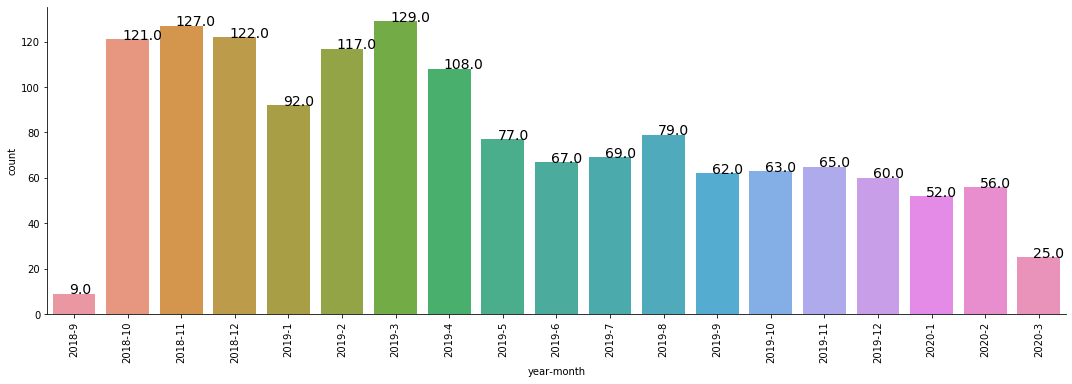

In [24]:
pipline = [{'$group':
               {'_id':
                  { 'Year': {'$year': '$datetime'},
                    'Month': {'$month': '$datetime'} },
                    'count': {'$sum': 1} }  },
            {'$sort': {'_id.Year': 1, '_id.Month': 1}   }]

mongo_cursor = coll_posts.aggregate(pipline)

datapoint = list(mongo_cursor)
df = json_normalize(datapoint)  

# df = pd.DataFrame(list(mongo_cursor))
df['year-month'] = df['_id.Year'].astype(str) +'-'+ df['_id.Month'].astype(str)

bar_categories(df, {'x':'year-month', 'y': 'count', 'kind': 'bar',})


### Вывод:
* Дата сет содержит последние 1500 поство из сообщества (цифра выбрана произвольно)
* Сентябрь 2018 и март 2020 - данные не полны.
* можно отметить, что происходит снижение количества постов в сообществе с 100+ до уровня 50+ 

## 4.2. Распределение постов по времени в течение дня - обзор датасета

ipykernel_launcher:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


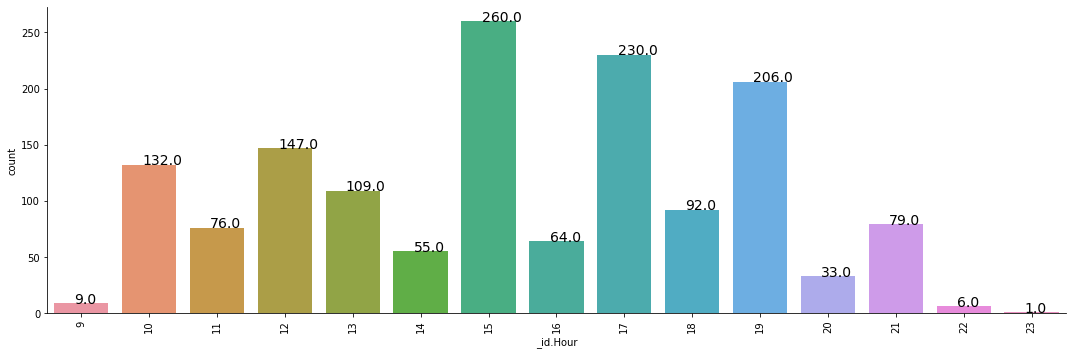

In [25]:
pipline = [{'$group': 
                {'_id': 
                  {'Hour': {'$hour': '$datetime'}},
                  'count': {'$sum': 1}  }  },
            {'$sort': {'_id.Hour': 1}}  ]

mongo_cursor = coll_posts.aggregate(pipline)
df = json_normalize(mongo_cursor)

bar_categories(df, {'x':'_id.Hour', 'y': 'count', 'kind': 'bar',})

### Вывод:
* Время публикации постов достаточно четко определено редакционной политикой.
* Наибольший пик это 15, 17, 19 - обеденное время, конец работчего дня, дорога домой.
* отдельно можно выделить публикации с 10 до 14 часов.

## 4.3. Среднемесячное количество лайков - обзор датасета

ipykernel_launcher:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


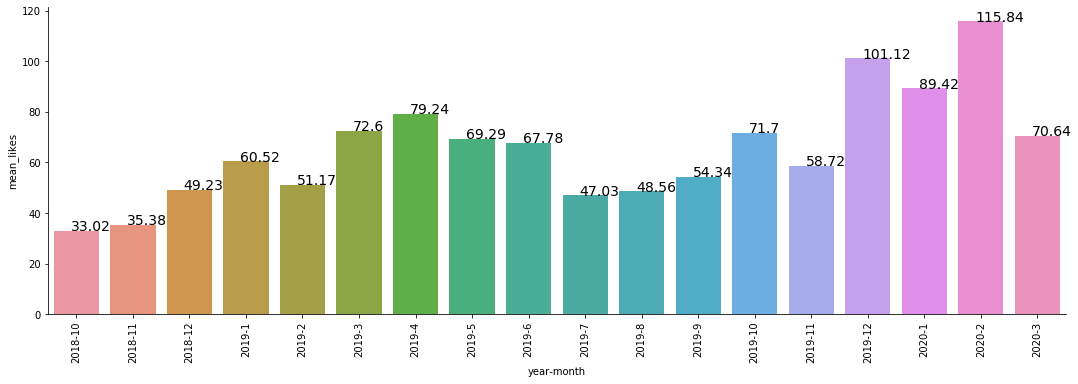

In [26]:
pipline = [{'$group': 
                {"_id":
                  {"Year" : {'$year': "$datetime"},
                   "Month": {'$month': "$datetime"} },
                   "mean_likes" : {'$avg': "$likes"} }  },
            {'$sort': {"_id.Year": 1, "_id.Month": 1}} ]

mc = coll_posts.aggregate(pipline)
df = json_normalize(mc)
df['year-month'] = df['_id.Year'].astype(str) +'-'+ df['_id.Month'].astype(str)
bar_categories(df, {'x':'year-month', 'y': 'mean_likes', 'kind': 'bar',})

### Вывод:
* представлено среднемесячное количество лайков по отношению ко всем постам за месяц.
* Снижение в 18-19 годах связано со снижением количеств постов, а рост с сенбярюя 2019 года, может говорить о росте вовлечённость участников сообщества.

## 4.4. Среднемесячное количество просомотров постов за месяц - обзор датасета

ipykernel_launcher:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


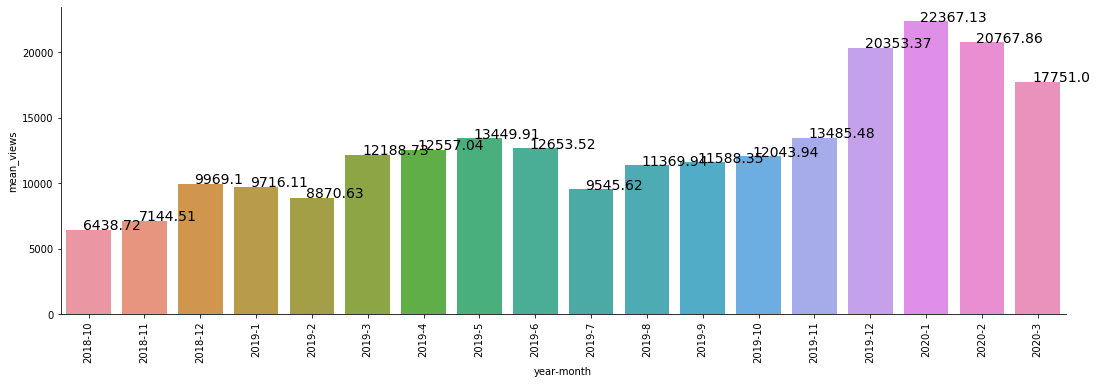

In [27]:
pipline = [{'$group':
               {"_id":
                  {"Year" : {'$year': "$datetime"},
                   "Month": {'$month': "$datetime"} },
                   "mean_views" : {'$avg': "$views"} }  },
            {'$sort': {"_id.Year": 1, "_id.Month": 1}} ]

mc = coll_posts.aggregate(pipline)
df = json_normalize(mc)
df['year-month'] = df['_id.Year'].astype(str) +'-'+ df['_id.Month'].astype(str)
bar_categories(df, {'x':'year-month', 'y': 'mean_views', 'kind': 'bar',})

### Вывод:
* Весьма странным выглядит столь значительный рост в декабре 2019 года, что может быть связнано или с очень успешной промоактивностью, или увеличением числа ботов.
* Декабрь и январь 2018 не показывают столь выдающийся прирост как декарь и январь 2020 по сравнению с предыдущими месяцами.

## 4.5. Среднемесячное количество просомотров постов в расчёте на количество постов в месяц - обзор датасета

ipykernel_launcher:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


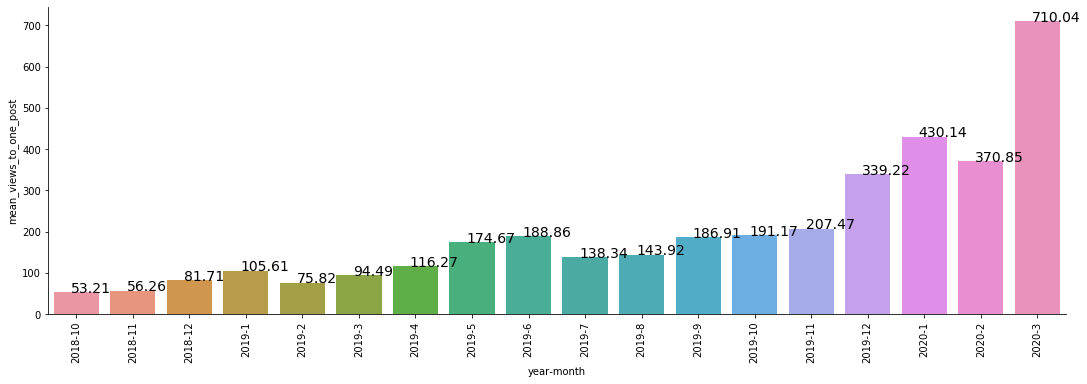

In [28]:
# TODO - просмотры на один пост (среднее + деление)
pipline = [{'$group':
               {"_id":
                  {"Year" : {'$year': "$datetime"},
                   "Month": {'$month': "$datetime"} },
                   "count_posts": {'$sum': 1},
                   "mean_views" : {'$avg': "$views"} }  },
            {'$project': {"name": 1, "mean_views_to_one_post": {'$divide':["$mean_views", "$count_posts"]}}},
            {'$sort': {"_id.Year": 1, "_id.Month": 1}} ]

mc = coll_posts.aggregate(pipline)
df = json_normalize(mc)
df['year-month'] = df['_id.Year'].astype(str) +'-'+ df['_id.Month'].astype(str)
bar_categories(df, {'x':'year-month', 'y': 'mean_views_to_one_post', 'kind': 'bar',})

### Вывод:
* Пересчёт на количества просмотров на количество постов в месяц, также показвают прирост в декабре 2019, январе 2020.

## 4.6. Средняя длина поста в символах - обзор датасета

ipykernel_launcher:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


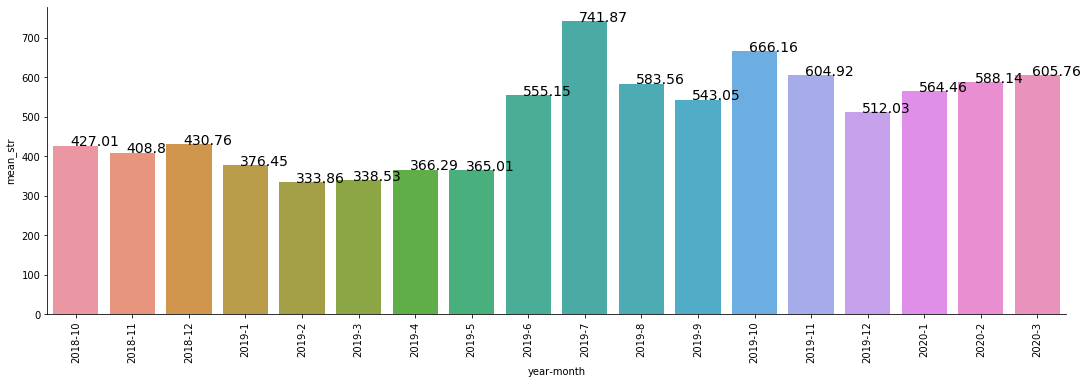

In [29]:
pipline = [{'$group': {"_id": {"Year" : {'$year': "$datetime"},
                               "Month": {'$month': "$datetime"} },
                             "mean_str" : {'$avg': {'$strLenCP': "$text"}} }  },
             {'$sort': {"_id.Year": 1, "_id.Month": 1}} ]

mc = coll_posts.aggregate(pipline)
df = json_normalize(mc)
df['year-month'] = df['_id.Year'].astype(str) +'-'+ df['_id.Month'].astype(str)
bar_categories(df, {'x':'year-month', 'y': 'mean_str', 'kind': 'bar',})

### Вывод:
* С лета 2019 года посты становятся более содержательнымии - их длина в символах растёт.
* Вероятно установлена была новая метрика для авторов в 500-650 символов.

## 4.7. Распределение постов по категориям - обзор датасета
* _у поста может быть более одной категории_

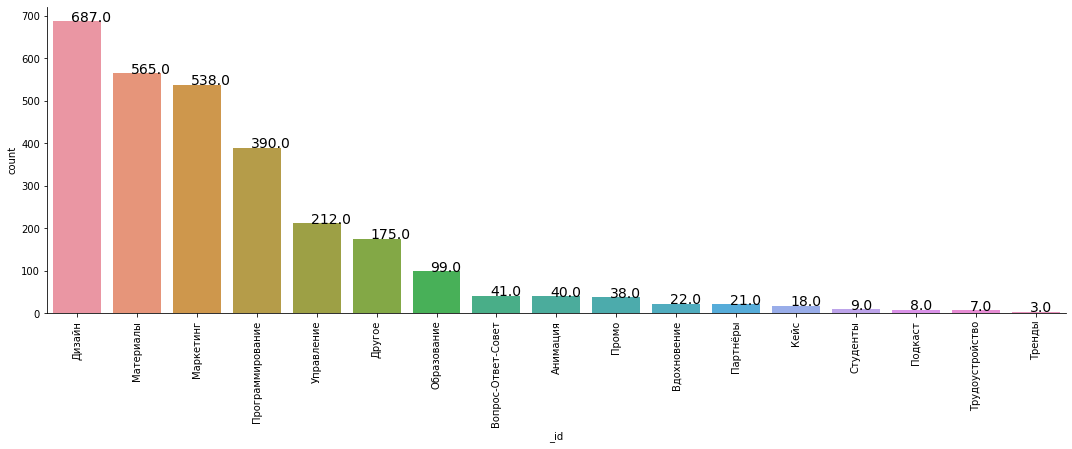

In [30]:
pipline = [{'$unwind': "$category"},
           {'$group': {"_id": "$category",
                       "count": {'$sum': 1} }  },
            {'$sort': {"_id.count": 1}}]
mc = coll_posts.aggregate(pipline)
df = pd.DataFrame(list(mc)).sort_values('count', ascending=False)
bar_categories(df, {'x':'_id', 'y': 'count', 'kind': 'bar',})

### Вывод:
* Наиболее число постов отмечается в категорияз: Дизайн и Маркетинг - так как они более наглядны и их проще визуализирвоать по сранвению с програмированием и дизайном.

## 4.8. Распределение комментаторов по странам и городам - обзор датасета
* Из графиков исключены (для читабельности) занимающие:
  * _1 место по странам - Россия (более 4000 комменаторов)_
  * _1 место по городам - Москва (более 950)_
  * _2 место по городам - Санкт-Петербург (более 510)_

### 4.8.1. Распределение комментаторов по странам

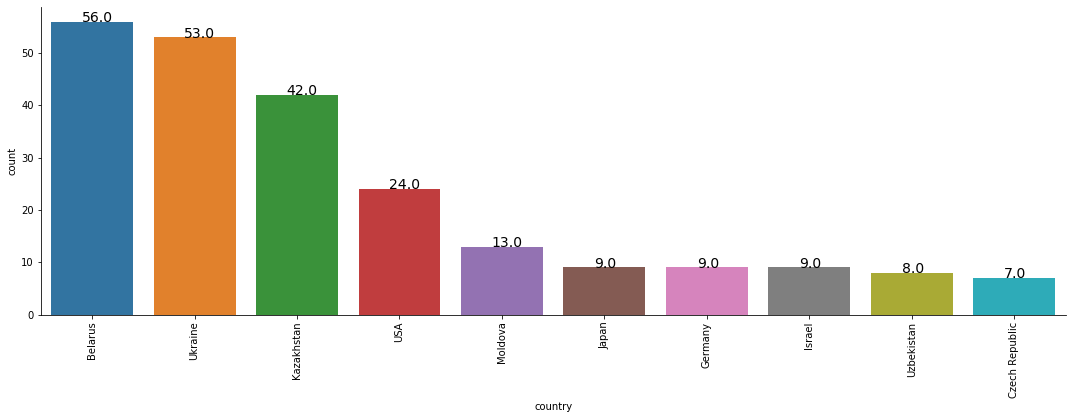

In [31]:
pipline = [{"$match": {"country.title": {'$ne': None}}},
           {'$group': 
               {"_id": "$country.title",
                        "count": {'$sum': 1} } },
            {'$project': 
                {"country":"$_id", "count": 1, "_id":0}},
            {'$sort': {'count': -1}}  ]

mc = coll_profiles.aggregate(pipline)

df = pd.DataFrame(list(mc)).sort_values('count', ascending=False)[1:11]
bar_categories(df, {'x':'country', 'y': 'count', 'kind': 'bar',})

### Вывод:
* Кроме России в число лидеров входят Украина, Беларусь, Казахстан. Можно учитывать их специфику и публиковать материалы о событиях происходящих в них связаынных с направлением публикаций.
* Менее интересными, выглядят США и Молдова.

### 4.8.2. Распределение комментаторов по городам

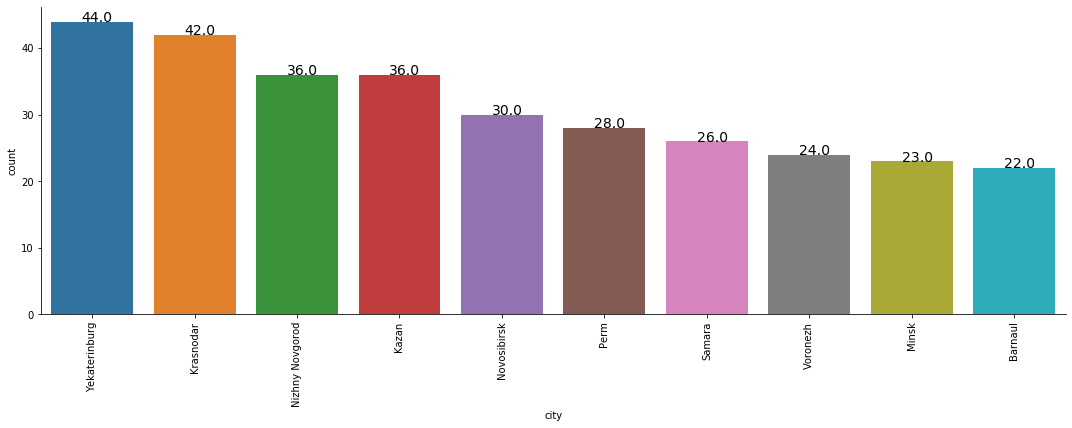

In [32]:
pipline = [{"$match": {"city.title": {'$ne': None}}},
           {'$group': 
               {"_id": "$city.title",
                        "count": {'$sum': 1} } },
            {'$project': 
                {"city":"$_id", "count": 1, "_id":0}},
            {'$sort': {'count': -1}} ]

mc = coll_profiles.aggregate(pipline)
df = pd.DataFrame(list(mc)).sort_values('count', ascending=False)[2:12]
bar_categories(df, {'x':'city', 'y': 'count', 'kind': 'bar',})

### Вывод:
* интересным выглядит распределение коментаторов по городам.
* интуитивно можно предоложить, что Казань и Новосибирск должны были занять более высокие места в связи с направленностью их университетов на ИТ.

## 4.9. Распределение комментаторов по возрасту - обзор датасета

### 4.9.1. Распределение комментаторов по возрасту - полное

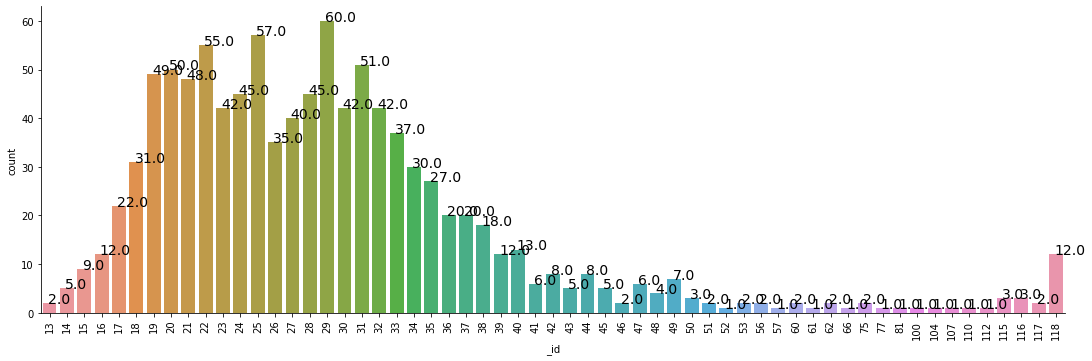

In [33]:
# Обязательно делать проверку на существование поля, иначе не корректно отрабатывает запрос
# Нужна конвертация строки (год) в Int

pipline = ([ {'$match': {"bdate": {'$exists': True}}},
             {'$project': {"bdate": 1, "bdate_len": {'$strLenCP': "$bdate"}} },
             {'$match': {"bdate_len": {'$gte': 8}}},
             {'$project': {"bdate": 1, "year": {'$split': ["$bdate", "."]}} },
             {'$unwind': "$year"},
             {'$addFields': {"int_year": {'$toInt': '$year'} }},
             {'$match': {"int_year": {'$gt': 1800}}},
             {'$addFields': {"age": {'$subtract': [2020, '$int_year']} }},
             {'$group': {"_id": "$age", "count": {'$sum': 1}}},
             {'$sort': {'count': -1}}
          ])

mc = coll_profiles.aggregate(pipline)
df = pd.DataFrame(list(mc)).sort_values('_id', ascending=True)
df1545 = df.copy()[:31]
df45 = df.copy()[30:]
bar_categories(df, {'x':'_id', 'y': 'count', 'kind': 'bar',})

### 4.9.2. Распределение комментаторов по возрасту - 15-45

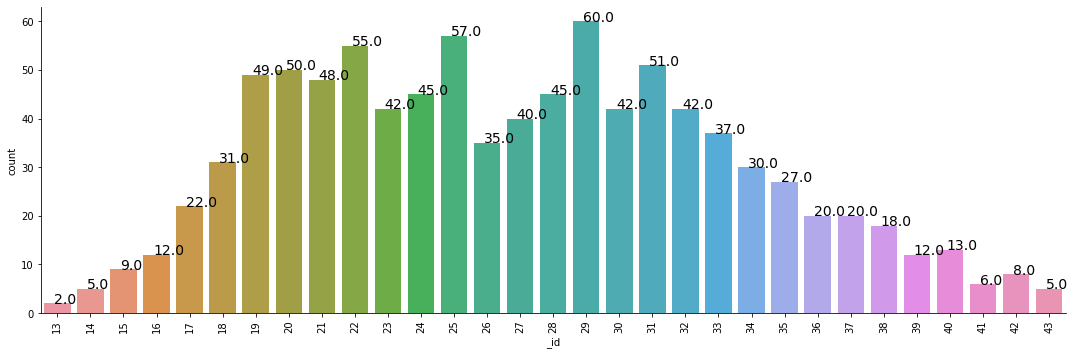

In [34]:
bar_categories(df1545, {'x':'_id', 'y': 'count', 'kind': 'bar',})

### Вывод:
* Можно выделить две группы от 19 до 25 лет и от 26 до 34.
* Вероятно учёт этого возростного фактора позволит лучше ориентировать промо-компании.
  * для тех кто хочет выучить новую профессию и сейчас скорее всего учится.
  * для тех кто хочет переквалифицироваться или добрать новые навыки.

### 4.9.3. Распределение комментаторов по возрасту - 45 - ...

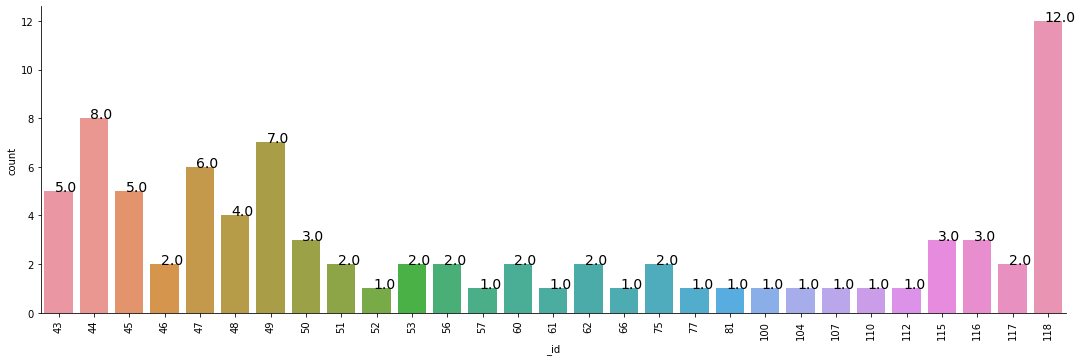

In [35]:
bar_categories(df45, {'x':'_id', 'y': 'count', 'kind': 'bar',})

### Вывод:
* В комментатороах есть всякие шутники с возрастом 118 лет 😂

## 4.10. Расспределение комментариев по времени

ipykernel_launcher:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


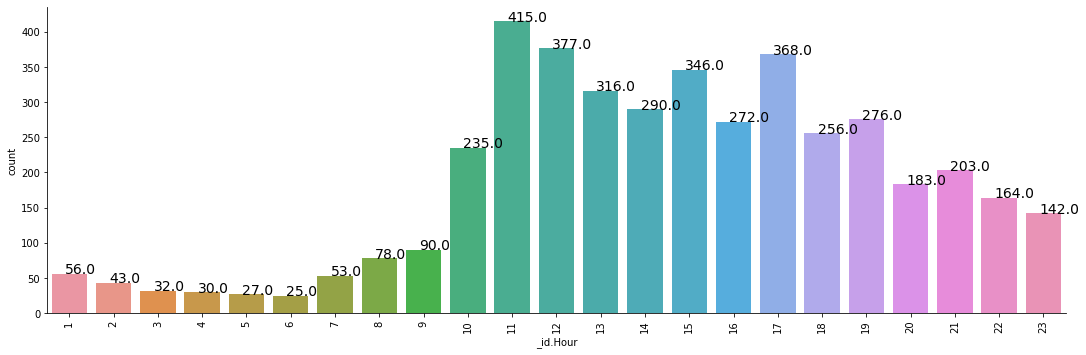

In [36]:
pipline = [{'$group':
                 {'_id': 
                    {'Hour': {'$hour': '$datetime'}},
                     'count': {'$sum': 1}} },
            {'$sort': {'_id.Hour': 1}} ]

mc = coll_comments.aggregate(pipline)
df = json_normalize(mc)

bar_categories(df, {'x':'_id.Hour', 'y': 'count', 'kind': 'bar',})

### Вывод:
* Комментарии пишутся достаточно равномерно начиная с пика в 11 утра и постепенно снижается к 23 часам.
+ Можно добавить 11 часов в задачи для авторов постов, т.к. это время не закрыть публикациями, возможно публикация в это время позволит задержать комментаторов на большее количество времени в паблике и увеличить его вовлечённость.

## 4.11. Расспределение комментаторов (работа\учёба) - в текущее время

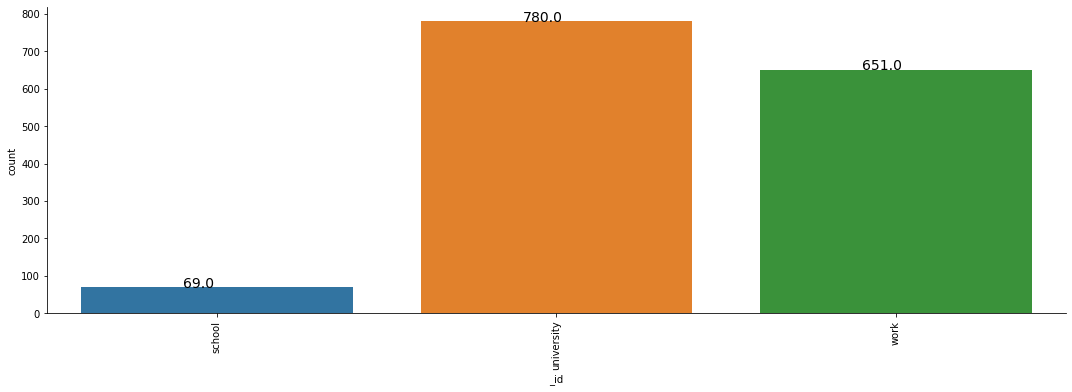

In [37]:
pipline = [{'$match': {'occupation': {'$exists': True}}},
           {'$group': 
               {'_id': '$occupation.type',
                'count': {'$sum': 1}}}
           ]


mc = coll_profiles.aggregate(pipline)
df = pd.DataFrame(list(mc)).sort_values('_id', ascending=True)
bar_categories(df, {'x':'_id', 'y': 'count', 'kind': 'bar',})

### Вывод:
* распределение коррелирует с распределнием по возрасту и позволяет выделить 2 группы.
* Школьники предствалены в значительно меньшем объеме.

## 4.12. Отношение к алкоголю и курению
1. резко негативное;
2. негативное;
3. компромиссное;
4. нейтральное;
5. положительное.

### 4.12.1 Отношение к курению

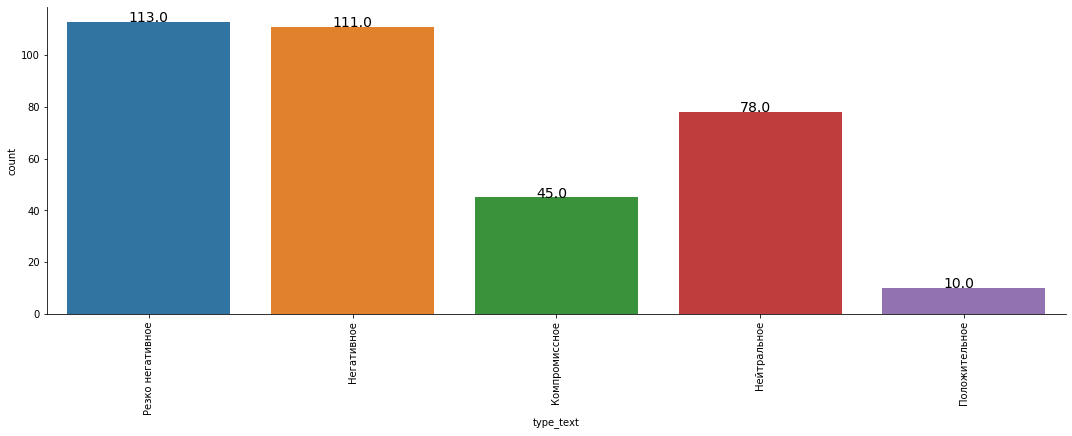

In [38]:
pipline = [{'$match': {'personal.smoking': {'$exists': True, '$ne':0}}},
           {'$group': {'_id': '$personal.smoking',
                       'count': {'$sum': 1}}},
            {'$project': {'type': '$_id', 'count': 1}},
            {"$addFields":
             {'type_text':
               {'$switch':
                 {'branches':
                  [ {'case': {'$eq': ['$type', 1]}, 'then': 'Резко негативное'},
                    {'case': {'$eq': ['$type', 2]}, 'then': 'Негативное'},
                    {'case': {'$eq': ['$type', 3]}, 'then': 'Компромиссное'},
                    {'case': {'$eq': ['$type', 4]}, 'then': 'Нейтральное'},
                    {'case': {'$eq': ['$type', 5]}, 'then': 'Положительное'}
                     ],
                    'default': 'ОШИБКА'
                  }}}},
            {'$sort': {'_id': 1}}]

mc = coll_profiles.aggregate(pipline)
df = pd.DataFrame(list(mc)).sort_values('_id', ascending=True)
bar_categories(df, {'x':'type_text', 'y': 'count', 'kind': 'bar',})

### Вывод:
* Большинство комменаторов не одобряет курение.

### 4.12.2 Отношение к алкоголю

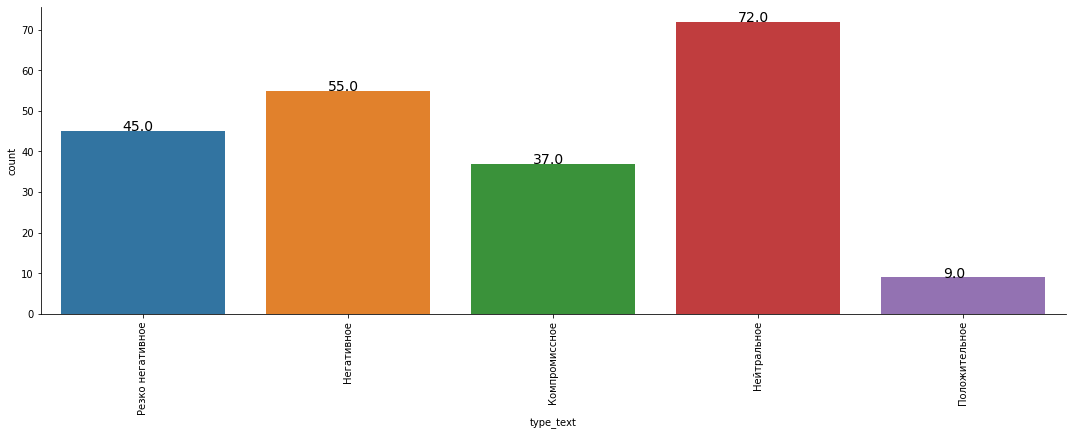

In [39]:
pipline = [{'$match': {'personal.alcohol': {'$exists': True, '$ne':0}}},
           {'$group': {'_id': '$personal.alcohol',
                       'count': {'$sum': 1}}},
            {'$project': {'type': '$_id', 'count': 1}},
            {"$addFields":
             {'type_text':
               {'$switch':
                 {'branches':
                  [ {'case': {'$eq': ['$type', 1]}, 'then': 'Резко негативное'},
                    {'case': {'$eq': ['$type', 2]}, 'then': 'Негативное'},
                    {'case': {'$eq': ['$type', 3]}, 'then': 'Компромиссное'},
                    {'case': {'$eq': ['$type', 4]}, 'then': 'Нейтральное'},
                    {'case': {'$eq': ['$type', 5]}, 'then': 'Положительное'}
                     ],
                    'default': 'ОШИБКА'
                  }}}},
            {'$sort': {'_id': 1}}]

mc = coll_profiles.aggregate(pipline)
df = pd.DataFrame(list(mc)).sort_values('_id', ascending=True)
bar_categories(df, {'x':'type_text', 'y': 'count', 'kind': 'bar',})

### Вывод:
* Отношение к алкоголю значительно более терпимее, чем к курению.

## 4.13. Религиозные воззрения комментаторов

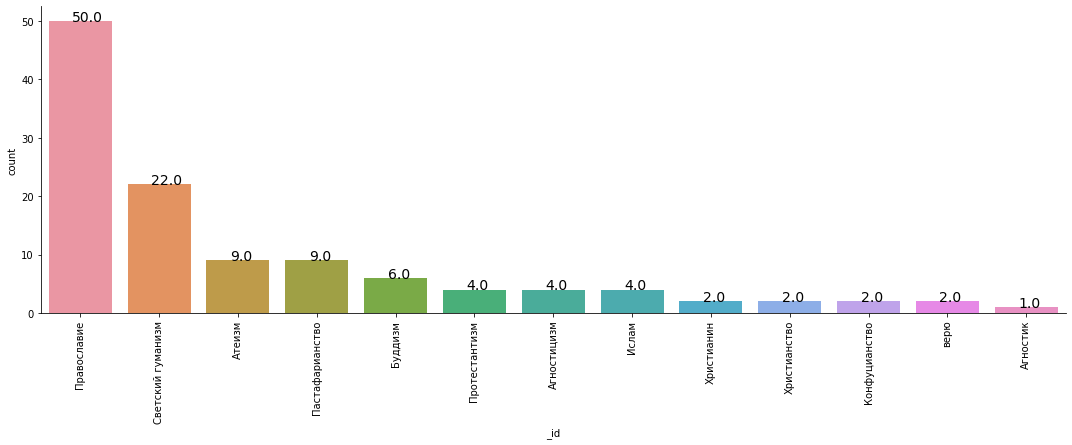

In [40]:
pipline =[{'$match': {'personal.religion': {'$exists': True, '$ne':0}}},
          {'$group': {'_id': '$personal.religion',
                      'count': {'$sum': 1}}},
          {'$sort': {'count':1}}
]

mc = coll_profiles.aggregate(pipline)
df = pd.DataFrame(list(mc)).sort_values('count', ascending=False)
df10 = df.copy()[:13]
df20 = df.copy()[14:]
bar_categories(df10, {'x':'_id', 'y': 'count', 'kind': 'bar',})

### Вывод:
* Значительное количество коментаторов занимают приверженцы веры в макоронного монстра 😂 обгоняя протестантов, будистов и мусульман.
* Пастафарианство, как показал исследование не потеряло своей актуальности и в 2020 году, по прошествие 15 лет с его появления.

#